# Programa para calcular los días de heladas en un determinado periodo

### `IMPORTAMOS PAQUETES`

In [2]:
# Required packages to load data 
import fsspec
import aiohttp
import xarray as xr

# Required packages for ploting 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.lines import Line2D
import cartopy.crs as ccrs


from datetime import datetime

import requests
import re

import geopandas as gpd
from shapely.geometry import mapping, box
import numpy as np

## PRUEBA PARA UNA SOLA HORA

### `ENTRAMOS EN LA WEB DE DESCARGA DE PRODUCTOS DE LSA SAF`

In [3]:
now = datetime.now() 
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")

http_user="valensat"
http_password="ValensatMola"
fs = fsspec.filesystem('https',client_kwargs={'auth': aiohttp.BasicAuth(http_user, http_password)})

product = 'MLST'
url_path = 'https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/{}/NETCDF/{}/{}/{}/'.format(product, year, month, day)

r = requests.get(url_path, auth=(http_user, http_password))
r1 = re.findall('/PRODUCTS/MSG/{}/NETCDF/{}/{}/{}/+\w+\w-+\w+\w'.format(product, year, month, day), r.text)

ds = xr.open_dataset(fs.open('https://datalsasaf.lsasvcs.ipma.pt/'+r1[-1]+'.nc'),engine='h5netcdf')
pvar = ds['LST'].isel(time=0)

hora_img = ds.image_reference_time[11:-4]

### `CARGAMOS LÍMITES DE LA COMUNIDAD`

In [4]:
cval = gpd.read_file('./data/delimitacion_cval/provincias/cval_provincias.shp')
pvar.rio.write_crs("epsg:4326", inplace=True)
pvar_cval = pvar.rio.clip(cval.geometry.apply(mapping), cval.crs)
mat_val = np.loadtxt('./data/mask_val.csv', delimiter=',')
mask_val =  xr.DataArray(mat_val,pvar_cval.coords,pvar_cval.dims)

### `REPRESENTAMOS PRODUCTO`

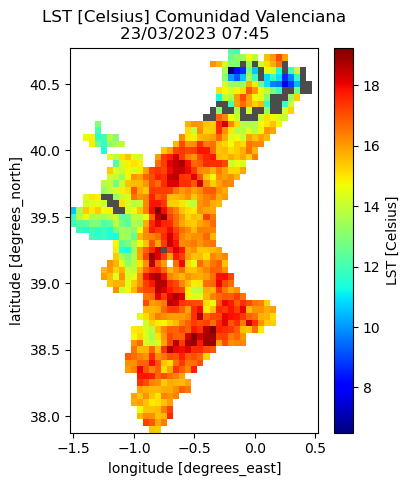

In [5]:
cmap_mask = mpl.colors.ListedColormap([(0, 0, 0, 0.7)])

f, ax = plt.subplots(figsize=(4, 5))
mask_val.plot(ax=ax, cmap=cmap_mask, add_colorbar=False)
pvar_cval.plot(ax=ax, cmap='jet')
ax.set_title('LST [Celsius] Comunidad Valenciana\n' + day + '/' + month + '/' + year + ' '+ hora_img)
# ax.set_axis_off()
plt.show()

### `CREAMOS MATRIZ DE HELADAS (TEMPERATURAS MENORES A 0°C)`

In [6]:
mat1 = pvar_cval <= 0
mat2 = np.where(mat1, 1, np.nan)
mat3 = xr.DataArray(mat2,pvar_cval.coords,pvar_cval.dims)

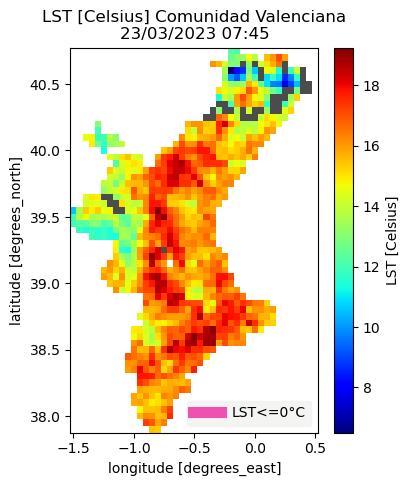

In [7]:
cmap_mask = mpl.colors.ListedColormap([(0, 0, 0, 0.7)])
cmap_hel = mpl.colors.ListedColormap([(238/255,81/255,177/255,1)])

f, ax = plt.subplots(figsize=(4, 5))
mask_val.plot(ax=ax, cmap=cmap_mask, add_colorbar=False)
pvar_cval.plot(ax=ax, cmap='jet')
mat3.plot(ax=ax, cmap = cmap_hel, add_colorbar=False)
ax.set_title('LST [Celsius] Comunidad Valenciana\n' + day + '/' + month + '/' + year + ' '+ hora_img)
custom_lines = [Line2D([0], [0], color=(238/255,81/255,177/255,1), lw=8)]
ax.legend(custom_lines, ['LST<=0°C'], loc='lower right', facecolor=(0.949, 0.949, 0.9412), edgecolor=(0.949, 0.949, 0.9412))
plt.show()

## PRUEBA PARA UN DÍA ENTERO

In [143]:
day = '21'
month = '03'
year = '2023'

http_user="valensat"
http_password="ValensatMola"
fs = fsspec.filesystem('https',client_kwargs={'auth': aiohttp.BasicAuth(http_user, http_password)})

product = 'MLST'
url_path = 'https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/{}/NETCDF/{}/{}/{}/'.format(product, year, month, day)

r = requests.get(url_path, auth=(http_user, http_password))
r1 = re.findall('/PRODUCTS/MSG/{}/NETCDF/{}/{}/{}/+\w+\w-+\w+\w'.format(product, year, month, day), r.text)

list_length=np.arange(0, len(r1), 1)

mat5 = np.zeros(pvar_cval.shape)
for i in list_length:
    ds = xr.open_dataset(fs.open('https://datalsasaf.lsasvcs.ipma.pt/'+r1[i]+'.nc'),engine='h5netcdf')
    pvar = ds['LST'].isel(time=0)

    hora_img = ds.image_reference_time[11:-4]

    pvar.rio.write_crs("epsg:4326", inplace=True)
    pvar_cval = pvar.rio.clip(cval.geometry.apply(mapping), cval.crs)

    mat1 = pvar_cval <= 0
    mat2 = np.where(mat1, 1, np.nan)
    mat3 = xr.DataArray(mat2,pvar_cval.coords,pvar_cval.dims)

    mat4 = np.where(mat1, 1, 0)
    mat5 = mat5 + mat4
    
    # cmap_mask = mpl.colors.ListedColormap([(0, 0, 0, 0.7)])
    # cmap_hel = mpl.colors.ListedColormap([(238/255,81/255,177/255,1)])

    # f, ax = plt.subplots(figsize=(4, 5))
    # mask_val.plot(ax=ax, cmap=cmap_mask, add_colorbar=False)
    # pvar_cval.plot(ax=ax, cmap='jet')
    # mat3.plot(ax=ax, cmap = cmap_hel, add_colorbar=False)
    # ax.set_title('LST [Celsius] Comunidad Valenciana\n' + day + '/' + month + '/' + year + ' '+ hora_img)
    # custom_lines = [Line2D([0], [0], color=(238/255,81/255,177/255,1), lw=8)]
    # ax.legend(custom_lines, ['LST<=0°C'], loc='lower right', facecolor=(0.949, 0.949, 0.9412), edgecolor=(0.949, 0.949, 0.9412))
    # plt.savefig('./MSG/images6/img{}_{}_{}_{}.png'.format(i+10, day, month, year), bbox_inches='tight')
    # plt.close()

In [152]:
mat6 = np.where(mat5>=1, 1, mat5)
mat6 = np.where(mat6 == 0, np.nan, mat6)
mask_heladas =  xr.DataArray(mat6,pvar_cval.coords,pvar_cval.dims)

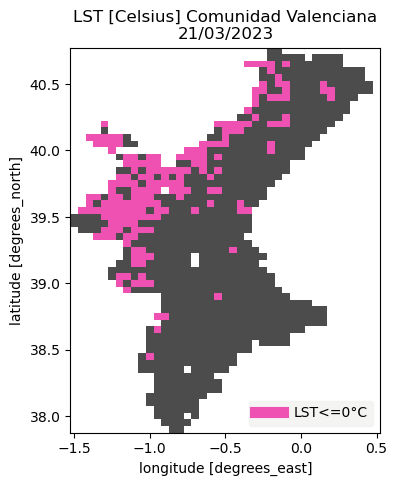

In [156]:
cmap_mask = mpl.colors.ListedColormap([(0, 0, 0, 0.7)])
cmap_hel = mpl.colors.ListedColormap([(238/255,81/255,177/255,1)])

f, ax = plt.subplots(figsize=(4, 5))
mask_val.plot(ax=ax, cmap=cmap_mask, add_colorbar=False)
# pvar_cval.plot(ax=ax, cmap='jet')
mask_heladas.plot(ax=ax, cmap = cmap_hel, add_colorbar=False)
ax.set_title('LST [Celsius] Comunidad Valenciana\n' + day + '/' + month + '/' + year)
custom_lines = [Line2D([0], [0], color=(238/255,81/255,177/255,1), lw=8)]
ax.legend(custom_lines, ['LST<=0°C'], loc='lower right', facecolor=(0.949, 0.949, 0.9412), edgecolor=(0.949, 0.949, 0.9412))
plt.show()

## PRUEBA PARA UN MES ENTERO

In [8]:
list_days=np.arange(1, 29, 1)
list_length1=np.arange(0, 28, 1)
mat7 = np.zeros(pvar_cval.shape)
for j in list_length1:
    day = str(list_days[j]).zfill(2)
    month = '02'
    year = '2023'

    http_user="valensat"
    http_password="ValensatMola"
    fs = fsspec.filesystem('https',client_kwargs={'auth': aiohttp.BasicAuth(http_user, http_password)})

    product = 'MLST'
    url_path = 'https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/{}/NETCDF/{}/{}/{}/'.format(product, year, month, day)

    r = requests.get(url_path, auth=(http_user, http_password))
    r1 = re.findall('/PRODUCTS/MSG/{}/NETCDF/{}/{}/{}/+\w+\w-+\w+\w'.format(product, year, month, day), r.text)

    list_length2=np.arange(0, len(r1), 1)

    mat5 = np.zeros(pvar_cval.shape)
    for i in list_length2:
        ds = xr.open_dataset(fs.open('https://datalsasaf.lsasvcs.ipma.pt/'+r1[i]+'.nc'),engine='h5netcdf')
        pvar = ds['LST'].isel(time=0)

        hora_img = ds.image_reference_time[11:-4]

        pvar.rio.write_crs("epsg:4326", inplace=True)
        pvar_cval = pvar.rio.clip(cval.geometry.apply(mapping), cval.crs)

        mat1 = pvar_cval <= 0
        mat2 = np.where(mat1, 1, np.nan)
        mat3 = xr.DataArray(mat2,pvar_cval.coords,pvar_cval.dims)

        mat4 = np.where(mat1, 1, 0)
        mat5 = mat5 + mat4
        
        cmap_mask = mpl.colors.ListedColormap([(0, 0, 0, 0.7)])
        cmap_hel = mpl.colors.ListedColormap([(238/255,81/255,177/255,1)])

        f, ax = plt.subplots(figsize=(4, 5))
        mask_val.plot(ax=ax, cmap=cmap_mask, add_colorbar=False)
        pvar_cval.plot(ax=ax, cmap='jet')
        mat3.plot(ax=ax, cmap = cmap_hel, add_colorbar=False)
        ax.set_title('LST [Celsius] Comunidad Valenciana\n' + day + '/' + month + '/' + year + ' '+ hora_img)
        custom_lines = [Line2D([0], [0], color=(238/255,81/255,177/255,1), lw=8)]
        ax.legend(custom_lines, ['LST<=0°C'], loc='lower right', facecolor=(0.949, 0.949, 0.9412), edgecolor=(0.949, 0.949, 0.9412))
        plt.savefig('./MSG/images8/img{}_{}_{}_{}.png'.format(i+10, day, month, year), bbox_inches='tight')
        plt.close()
    
    mat6 = np.where(mat5>=1, 1, mat5)
    mat7 = mat7 + mat6
    
np.savetxt('./heladas/csv_mes/mat7_{}_{}_{}'.format(day, month, year), mat7, delimiter=',')

In [9]:
mat8 = np.loadtxt('./heladas/csv_mes/mat7_{}_{}_{}'.format(day, month, year), delimiter=',')
mat8 = np.where(mat8 == 0, np.nan, mat8)
mask_heladas_mes =  xr.DataArray(mat8,pvar_cval.coords,pvar_cval.dims)

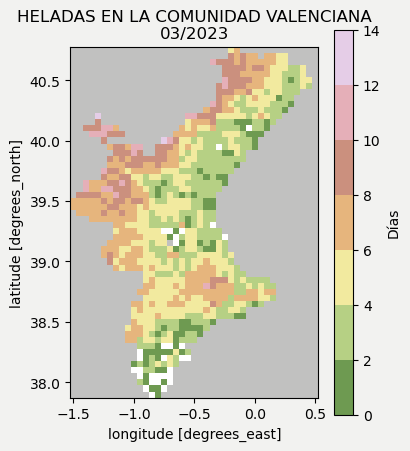

In [62]:
# cmap_dias = colors.ListedColormap([(110/255,154/255,81/255,255/255), (182/255,208/255,132/255,255/255), (242/255,234/255,159/255,255/255), (242/255,215/255,138/255,255/255), (230/255,181/255,125/255,255/255), (203/255,144/255,126/255,255/255), (229/255,175/255,184/255,255/255), (229/255,205/255,231/255,255/255)])
# bounds_dias = [0, 5, 10, 15, 20, 25, 30, 35, 40]
# norm_dias = colors.BoundaryNorm(bounds_dias, cmap_dias.N)

cmap_dias = colors.ListedColormap([(110/255,154/255,81/255,255/255), (182/255,208/255,132/255,255/255), (242/255,234/255,159/255,255/255), (230/255,181/255,125/255,255/255), (203/255,144/255,126/255,255/255), (229/255,175/255,184/255,255/255), (229/255,205/255,231/255,255/255)])
bounds_dias = [0, 2, 4, 6, 8, 10, 12, 14]
norm_dias = colors.BoundaryNorm(bounds_dias, cmap_dias.N)

cmap_mask = mpl.colors.ListedColormap([(1, 1, 1, 1)])

f, ax = plt.subplots(figsize=(4, 5))
mask_val.plot(ax=ax, cmap=cmap_mask, add_colorbar=False)
mask_heladas_mes.plot(ax=ax, cmap=cmap_dias, norm=norm_dias, add_colorbar=False)
ax.set_title('HELADAS EN LA COMUNIDAD VALENCIANA\n' + month + '/' + year)
ax.set_facecolor((0, 0, 0, 0.2))
f.patch.set_facecolor((0.949, 0.949, 0.9412))
im = ax.imshow(np.random.random((10, 10)), cmap=cmap_dias, norm=norm_dias)
f.colorbar(im, ax=ax, label='Días')
plt.show()



In [135]:
mat4 = np.zeros(pvar_cval.shape)
# mat4[:] = np.nan

mat88 = np.zeros(pvar_cval.shape)
mat88[1] = 1
mat88[2] = 1

mat89 = np.zeros(pvar_cval.shape)
mat89[0] = 1
mat89[2] = 3

mat90 = mat4 + mat89 + mat88
mat90

mat92 = np.where(mat90>=1, 1, mat90)
mat92 = np.where(mat92 == 0, np.nan, mat92)
mat92

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [157]:
day

'21'

In [158]:
day2 = str(21)
day2

'21'

In [139]:
mat2 = np.where(mat1, 1, np.nan)
mat2

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [142]:
mat56 = np.where(mat1, 1, 0)
mat56

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])